In [1]:
# 라이브러리 불러오기
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision.models import resnet18
from torchvision import transforms
import torchaudio
import pandas as pd
import torch
import torch.nn as nn


In [2]:
##IDK what is wrong with that up cell
import torch
import subprocess

def GPU():
    if torch.cuda.is_available() == True:
        device = 'cuda'
        templist = [1, 2, 3]
        templist = torch.FloatTensor(templist).to(device)
        print("Cuda torch working : ", end="")
        print(templist.is_cuda)
        print("current device no. : ", end="")
        print(torch.cuda.current_device())
        print("GPU device count : ", end="")
        print(torch.cuda.device_count())
        print("GPU name : ", end="")
        print(torch.cuda.get_device_name(0))
        print("device : ", device)
        # Execute the nvidia-smi command using subprocess
        try:
            output = subprocess.check_output(['nvidia-smi']).decode('utf-8')
            print("nvidia-smi output:")
            print(output)
        except (subprocess.CalledProcessError, FileNotFoundError) as e:
            print("Error executing nvidia-smi command:", str(e))
    elif torch.backends.mps.is_available() == True:
        print("Apple device detected\nActivating Apple Silicon GPU")
        device = torch.device("mps")
    else:
        print("cant use gpu , activating cpu")
        device = 'cpu'

    return device
device = GPU()
print(device)

Apple device detected
Activating Apple Silicon GPU
mps


In [3]:
# To use 3 channel Resnet
class MonoToColor(nn.Module):
    def __init__(self, num_channels=3):
        super(MonoToColor, self).__init__()
        self.num_channels = num_channels

    def forward(self, tensor):
        return tensor.repeat(self.num_channels, 1, 1)

In [4]:
# Dataset 클래스 정의
class UrbanSoundDataset(Dataset):
    def __init__(self, annotations_file, audio_dir, transformation, target_sample_rate, selected_labels):
        self.annotations = annotations_file
        self.audio_dir = audio_dir
        self.transformation = transformation
        self.target_sample_rate = target_sample_rate
        self.selected_labels = selected_labels

        self.annotations = self.annotations[self.annotations['class'].isin(self.selected_labels)]
        self.annotations['classID'] = self.annotations['class'].astype('category').cat.codes

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, index):
        audio_sample_path = self._get_audio_sample_path(index)
        label = self._get_audio_sample_label(index)
        signal, sr = torchaudio.load(audio_sample_path)
        signal = self._resample_if_necessary(signal, sr)
        signal = self._mix_down_if_necessary(signal)
        signal = self._cut_if_necessary(signal)
        signal = self._right_pad_if_necessary(signal)
        signal = self.transformation(signal)
        return signal, torch.tensor(label, dtype=torch.long)

    def _cut_if_necessary(self, signal):
        if signal.shape[1] > self.target_sample_rate:
            signal = signal[:, :self.target_sample_rate]
        return signal

    def _right_pad_if_necessary(self, signal):
        length_signal = signal.shape[1]
        if length_signal < self.target_sample_rate:
            num_missing_samples = self.target_sample_rate - length_signal
            last_dim_padding = (0, num_missing_samples)
            signal = nn.functional.pad(signal, last_dim_padding)
        return signal

    def _resample_if_necessary(self, signal, sr):
        if sr != self.target_sample_rate:
            resampler = torchaudio.transforms.Resample(sr, self.target_sample_rate)
            signal = resampler(signal)
        return signal

    def _mix_down_if_necessary(self, signal):
        if signal.shape[0] > 1:
            signal = torch.mean(signal, dim=0, keepdim=True)
        return signal
    def _get_audio_sample_path(self, index):
        fold = f"fold{self.annotations.iloc[index, 5]}"
        file_name = self.annotations.iloc[index, 0]
        audio_sample_path = os.path.join(self.audio_dir, fold, file_name)
        return audio_sample_path
    def _get_audio_sample_label(self, index):
        return self.annotations.iloc[index, 6]


In [5]:
## New label

# Load the CSV data for the 'glass_shatter' class
data_glass_shatter = pd.read_csv("/Users/owo/HOUSE/@DUNE/@AI/Sound Classification/newsound/UrbanSound8K_for_glassshatter.csv")
data_glass_shatter.head()

,slice_file_name,fsID,start,end,salience,fold,classID,class
0,glass_shatter_0.wav,111111,3339.908526,3341.908526,1,11,11,glass_shatter
1,glass_shatter_1.wav,111111,42.272744,44.272744,1,11,11,glass_shatter
2,glass_shatter_2.wav,111111,2771.678095,2773.678095,1,11,11,glass_shatter
3,glass_shatter_3.wav,111111,232.600317,234.600317,1,11,11,glass_shatter
4,glass_shatter_4.wav,111111,1917.612925,1919.612925,1,11,11,glass_shatter


In [6]:
# Load the CSV data for the 'door_nock' class
data_door_nock = pd.read_csv("/Users/owo/HOUSE/@DUNE/@AI/Sound Classification/newsound/UrbanSound8K_for_doornock.csv")
data_door_nock.head()

,slice_file_name,fsID,start,end,salience,fold,classID,class
0,door_nock_0.wav,222222,2998.994467,3000.994467,1,11,12,door_nock
1,door_nock_1.wav,222222,665.285034,667.285034,1,11,12,door_nock
2,door_nock_2.wav,222222,478.739955,480.739955,1,11,12,door_nock
3,door_nock_3.wav,222222,259.646757,261.646757,1,11,12,door_nock
4,door_nock_4.wav,222222,965.875782,967.875782,1,11,12,door_nock


In [7]:
# Load the CSV data for the 'nothing' class
data_nothing = pd.read_csv("/Users/owo/HOUSE/@DUNE/@AI/Sound Classification/newsound/UrbanSound8K_for_nothing.csv")
data_nothing.head()

,slice_file_name,fsID,start,end,salience,fold,classID,class
0,nothing_0.wav,333333,78.249615,80.249615,1,11,13,nothing
1,nothing_1.wav,333333,641.007846,643.007846,1,11,13,nothing
2,nothing_2.wav,333333,3068.871111,3070.871111,1,11,13,nothing
3,nothing_3.wav,333333,1948.704762,1950.704762,1,11,13,nothing
4,nothing_4.wav,333333,2462.373787,2464.373787,1,11,13,nothing


In [8]:
# Load the CSV data for the 'nothing' class
data_nothing2 = pd.read_csv("/Users/owo/HOUSE/@DUNE/@AI/Sound Classification/newsound/UrbanSound8K_for_nothing2.csv")
data_nothing2.head()

,slice_file_name,fsID,start,end,salience,fold,classID,class
0,nothing2_0.wav,444444,7.209433,9.209433,1,11,14,nothing2
1,nothing2_1.wav,444444,17.097732,19.097732,1,11,14,nothing2
2,nothing2_2.wav,444444,11.108254,13.108254,1,11,14,nothing2
3,nothing2_3.wav,444444,15.482585,17.482585,1,11,14,nothing2
4,nothing2_4.wav,444444,17.830567,19.830567,1,11,14,nothing2


In [9]:
# 데이터셋 및 데이터 로더 설정
import pandas as pd


# Load the dataset
try:
    ANNOTATIONS_FILE = pd.read_csv('/Users/owo/HOUSE/@DUNE/@AI/Sound Classification/archive/UrbanSound8K.csv')
except:
    try:
        ANNOTATIONS_FILE = pd.read_csv('/Users/owo/sound_datasets/urbansound8k/UrbanSound8K/metadata/UrbanSound8K.csv')
    except:
        ANNOTATIONS_FILE = pd.read_csv('C:/Users/PC/AppData/@FOLDER/@Project/UrbanSound8K/metadata/UrbanSound8K.csv')

In [10]:
ANNOTATIONS_FILE = pd.concat([ANNOTATIONS_FILE, data_glass_shatter, data_door_nock,data_nothing,data_nothing2])
ANNOTATIONS_FILE = ANNOTATIONS_FILE.reset_index(drop=True)
ANNOTATIONS_FILE

,slice_file_name,fsID,start,end,salience,fold,classID,class
0,100032-3-0-0.wav,100032,0.000000,0.317551,1,5,3,dog_bark
1,100263-2-0-117.wav,100263,58.500000,62.500000,1,5,2,children_playing
2,100263-2-0-121.wav,100263,60.500000,64.500000,1,5,2,children_playing
3,100263-2-0-126.wav,100263,63.000000,67.000000,1,5,2,children_playing
4,100263-2-0-137.wav,100263,68.500000,72.500000,1,5,2,children_playing
...,...,...,...,...,...,...,...,...
12727,nothing2_995.wav,444444,10.613469,12.613469,1,11,14,nothing2
12728,nothing2_996.wav,444444,6.568073,8.568073,1,11,14,nothing2
12729,nothing2_997.wav,444444,10.650340,12.650340,1,11,14,nothing2
12730,nothing2_998.wav,444444,9.132744,11.132744,1,11,14,nothing2


In [11]:
import pandas as pd

# Assuming you have the ANNOTATIONS_FILE dataframe
# You can use the value_counts() function on the 'class' column
label_counts = ANNOTATIONS_FILE['class'].value_counts()

# Display the counts of files for each label in a tabular format
print(label_counts)


dog_bark            1000
children_playing    1000
air_conditioner     1000
street_music        1000
engine_idling       1000
jackhammer          1000
drilling            1000
glass_shatter       1000
door_nock           1000
nothing             1000
nothing2            1000
siren                929
car_horn             429
gun_shot             374
Name: class, dtype: int64


In [12]:
random = 1 # 1== random,  0 == fix seed

if random == 0:
    import random
    import numpy as np

    seed = 42
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)

In [14]:
import pandas as pd

# Assuming you have the ANNOTATIONS_FILE dataframe
# You can use the value_counts() function on the 'class' column
label_counts = ANNOTATIONS_FILE['class'].value_counts()

# Display the counts of files for each label in a tabular format
print(label_counts)


dog_bark            1000
children_playing    1000
air_conditioner     1000
street_music        1000
engine_idling       1000
jackhammer          1000
drilling            1000
glass_shatter       1000
door_nock           1000
nothing             1000
nothing2            1000
siren                929
car_horn             429
gun_shot             374
Name: class, dtype: int64


In [15]:
#AUDIO_DIR = "/Users/cafalena/sound_datasets/urbansound8k/UrbanSound8K/audio"##cafalena or owo
#AUDIO_DIR = "C:/Users/PC/AppData/@FOLDER/@Project/UrbanSound8K/audio"##cafalena or owo
AUDIO_DIR = "/Users/owo/HOUSE/@DUNE/@AI/Sound Classification/archive"##cafalena or owo

In [16]:
SAMPLE_RATE = 22050
BATCH_SIZE = 16
NUM_WORKERS = 0
PIN_MEMORY = True if torch.cuda.is_available() else False

In [17]:
transformation = transforms.Compose([
    torchaudio.transforms.MelSpectrogram(sample_rate=SAMPLE_RATE, n_mels=40),# higher the better but more complex. For talking we use 128, for sound effect, about 40.
    torchaudio.transforms.AmplitudeToDB(stype='power', top_db=80),
    MonoToColor()
])

/Users/owo/anaconda3/envs/torchenv/lib/python3.11/site-packages/torchaudio/functional/functional.py:576: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(


In [18]:
#selected_labels = ["air_conditioner", "car_horn", "children_playing", "dog_bark","drilling", "engine_idling", "gun_shot", "jackhammer", "siren", "street_music", "glass_shatter", "door_nock","nothing"]

selected_labels = ["door_nock","glass_shatter","car_horn","dog_bark","drilling","nothing","siren","nothing2"]

In [19]:
usd = UrbanSoundDataset(ANNOTATIONS_FILE, AUDIO_DIR, transformation, SAMPLE_RATE, selected_labels)

/var/folders/sb/2gzn9_qx589_ft0jp8q6nbbc0000gn/T/ipykernel_5089/231203154.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.annotations['classID'] = self.annotations['class'].astype('category').cat.codes


In [20]:
# 데이터셋 분리
dataset_size = len(usd)
train_size = int(0.8 * dataset_size)
val_size = int(0.1 * dataset_size)
test_size = dataset_size - train_size - val_size
train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(usd, [train_size, val_size, test_size])

# 데이터 로더 생성
train_loader = DataLoader(dataset=train_dataset,
                            batch_size=BATCH_SIZE,
                            shuffle=True,
                            num_workers=NUM_WORKERS,
                            pin_memory=PIN_MEMORY)

val_loader = DataLoader(dataset=val_dataset,
                            batch_size=BATCH_SIZE,
                            shuffle=True,
                            num_workers=NUM_WORKERS,
                            pin_memory=PIN_MEMORY)

test_loader = DataLoader(dataset=test_dataset,
                            batch_size=BATCH_SIZE,
                            shuffle=True,
                            num_workers=NUM_WORKERS,
                            pin_memory=PIN_MEMORY)


In [21]:
ANNOTATIONS_FILE

,slice_file_name,fsID,start,end,salience,fold,classID,class
0,100032-3-0-0.wav,100032,0.000000,0.317551,1,5,3,dog_bark
1,100263-2-0-117.wav,100263,58.500000,62.500000,1,5,2,children_playing
2,100263-2-0-121.wav,100263,60.500000,64.500000,1,5,2,children_playing
3,100263-2-0-126.wav,100263,63.000000,67.000000,1,5,2,children_playing
4,100263-2-0-137.wav,100263,68.500000,72.500000,1,5,2,children_playing
...,...,...,...,...,...,...,...,...
12727,nothing2_995.wav,444444,10.613469,12.613469,1,11,14,nothing2
12728,nothing2_996.wav,444444,6.568073,8.568073,1,11,14,nothing2
12729,nothing2_997.wav,444444,10.650340,12.650340,1,11,14,nothing2
12730,nothing2_998.wav,444444,9.132744,11.132744,1,11,14,nothing2


In [22]:
usd

In [23]:
len(selected_labels)

8

In [24]:
# ResNet18 모델 설정
model = resnet18(pretrained=False)
# Change the output neurons of the model
model.fc = nn.Linear(512, len(selected_labels)) 
# Use multiple GPUs if available
if torch.cuda.device_count() > 1:
  print("Let's use", torch.cuda.device_count(), "GPUs!")
  model = nn.DataParallel(model)
model = model.to(device)


/Users/owo/anaconda3/envs/torchenv/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/owo/anaconda3/envs/torchenv/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [25]:
# 손실함수와 옵티마이저 설정
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [26]:
# 학습률 스케줄러 설정
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [27]:
from tqdm import tqdm
import matplotlib.pyplot as plt

# Lists to store the training and validation loss and accuracy for each epoch
train_loss_list = []
train_acc_list = []
val_loss_list = []
val_acc_list = []

# 최고 검증 정확도를 저장하기 위한 변수 설정
best_acc = 0.0

# 모델 훈련 함수 정의
def train_model(model, dataloaders, criterion, optimizer, scheduler, num_epochs):
    global best_acc

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-' * 10)

        # 각 에포크(epoch)은 학습 단계와 검증 단계를 거칩니다.
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # 모델을 학습 모드로 설정
            else:
                model.eval()   # 모델을 평가 모드로 설정

            running_loss = 0.0
            running_corrects = 0

            # 데이터를 반복
            for inputs, labels in tqdm(dataloaders[phase]):
                #print(inputs.shape)
                inputs = inputs.to(device)
                labels = labels.to(device)

                # 매개변수 경사도를 0으로 설정
                optimizer.zero_grad()

                # 순전파
                # 학습 시에만 연산 기록을 추적
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # 학습 단계인 경우 역전파 + 최적화
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # 통계를 계산
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.float() / dataset_sizes[phase]

            # Save loss and accuracy for plotting
            if phase == 'train':
                train_loss_list.append(epoch_loss)
                train_acc_list.append(epoch_acc)
            else:
                val_loss_list.append(epoch_loss)
                val_acc_list.append(epoch_acc)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            
            # 모델을 깊은 복사(deep copy)함
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                # Save model at best acc
                torch.save(model.state_dict(),"ResNet18_02.pth")
                print('model saved')



    print('Best val Acc: {:4f}'.format(best_acc))

    # 가장 나은 모델 가중치를 불러옴
    model.load_state_dict(best_model_wts)
    return model

In [28]:
import copy
nb_epochs = 15
# 모델 훈련 시작
dataloaders = {"train": train_loader, "val": val_loader}
# define dataset_sizes
dataset_sizes = {'train': len(train_dataset), 'val': len(val_dataset)}

best_model = train_model(model, dataloaders, criterion, optimizer, scheduler, num_epochs=nb_epochs)

Epoch 0/14
----------


  0%|          | 0/368 [00:00<?, ?it/s]

100%|██████████| 368/368 [00:58<00:00,  6.31it/s]


train Loss: 0.6274 Acc: 0.7829


100%|██████████| 46/46 [00:04<00:00, 10.17it/s]


val Loss: 0.4074 Acc: 0.8721
model saved
Epoch 1/14
----------


100%|██████████| 368/368 [00:54<00:00,  6.77it/s]


train Loss: 0.3015 Acc: 0.8957


100%|██████████| 46/46 [00:04<00:00, 11.33it/s]


val Loss: 0.2855 Acc: 0.9020
model saved
Epoch 2/14
----------


100%|██████████| 368/368 [00:53<00:00,  6.88it/s]


train Loss: 0.2024 Acc: 0.9322


100%|██████████| 46/46 [00:04<00:00, 11.38it/s]


val Loss: 0.3297 Acc: 0.9007
Epoch 3/14
----------


100%|██████████| 368/368 [00:55<00:00,  6.68it/s]


train Loss: 0.1754 Acc: 0.9387


100%|██████████| 46/46 [00:04<00:00, 11.40it/s]


val Loss: 0.2021 Acc: 0.9347
model saved
Epoch 4/14
----------


100%|██████████| 368/368 [00:53<00:00,  6.93it/s]


train Loss: 0.1388 Acc: 0.9538


100%|██████████| 46/46 [00:03<00:00, 11.52it/s]


val Loss: 0.2458 Acc: 0.9265
Epoch 5/14
----------


100%|██████████| 368/368 [00:52<00:00,  6.95it/s]


train Loss: 0.1252 Acc: 0.9565


100%|██████████| 46/46 [00:04<00:00, 11.34it/s]


val Loss: 0.1906 Acc: 0.9361
model saved
Epoch 6/14
----------


100%|██████████| 368/368 [00:52<00:00,  6.95it/s]


train Loss: 0.1147 Acc: 0.9562


100%|██████████| 46/46 [00:04<00:00, 11.50it/s]


val Loss: 1.0092 Acc: 0.7687
Epoch 7/14
----------


100%|██████████| 368/368 [00:53<00:00,  6.93it/s]


train Loss: 0.0458 Acc: 0.9864


100%|██████████| 46/46 [00:04<00:00, 11.50it/s]


val Loss: 0.1150 Acc: 0.9578
model saved
Epoch 8/14
----------


100%|██████████| 368/368 [00:52<00:00,  6.95it/s]


train Loss: 0.0335 Acc: 0.9900


100%|██████████| 46/46 [00:04<00:00, 11.47it/s]


val Loss: 0.1074 Acc: 0.9646
model saved
Epoch 9/14
----------


100%|██████████| 368/368 [00:53<00:00,  6.90it/s]


train Loss: 0.0295 Acc: 0.9913


100%|██████████| 46/46 [00:04<00:00, 11.43it/s]


val Loss: 0.1103 Acc: 0.9660
model saved
Epoch 10/14
----------


100%|██████████| 368/368 [00:52<00:00,  6.96it/s]


train Loss: 0.0213 Acc: 0.9939


100%|██████████| 46/46 [00:04<00:00, 11.47it/s]


val Loss: 0.1035 Acc: 0.9660
Epoch 11/14
----------


100%|██████████| 368/368 [00:52<00:00,  6.97it/s]


train Loss: 0.0177 Acc: 0.9946


100%|██████████| 46/46 [00:04<00:00, 11.45it/s]


val Loss: 0.1120 Acc: 0.9646
Epoch 12/14
----------


100%|██████████| 368/368 [00:53<00:00,  6.94it/s]


train Loss: 0.0167 Acc: 0.9947


100%|██████████| 46/46 [00:04<00:00, 11.43it/s]


val Loss: 0.1147 Acc: 0.9660
Epoch 13/14
----------


100%|██████████| 368/368 [00:52<00:00,  6.96it/s]


train Loss: 0.0166 Acc: 0.9949


100%|██████████| 46/46 [00:03<00:00, 11.57it/s]


val Loss: 0.1148 Acc: 0.9741
model saved
Epoch 14/14
----------


100%|██████████| 368/368 [00:52<00:00,  6.96it/s]


train Loss: 0.0100 Acc: 0.9978


100%|██████████| 46/46 [00:03<00:00, 11.54it/s]

val Loss: 0.1164 Acc: 0.9741
Best val Acc: 0.974150


In [29]:
train_loss_list

[0.6274360283232043,
 0.3014733846699031,
 0.20241147689230177,
 0.17542096107661462,
 0.13881387118714686,
 0.12517644976295159,
 0.11466842925386782,
 0.045774271392563785,
 0.03354272431818337,
 0.029519794348056447,
 0.021272745520416667,
 0.01768493403221686,
 0.016684270236986737,
 0.016557993560647633,
 0.009968752661173877]

In [30]:
val_loss_list

[0.40744622045633744,
 0.2855112812146038,
 0.3296798236718794,
 0.202065010693203,
 0.24578302251238401,
 0.19058066816354285,
 1.0091970632676364,
 0.11503802292796524,
 0.10744078049474225,
 0.11031361532454588,
 0.10350207166435818,
 0.11202599261760661,
 0.11473209807034708,
 0.11482703460215711,
 0.11644881799671368]

In [31]:
train_acc_list = torch.tensor(train_acc_list).detach().cpu()

In [32]:
val_acc_list = torch.tensor(val_acc_list).detach().cpu()

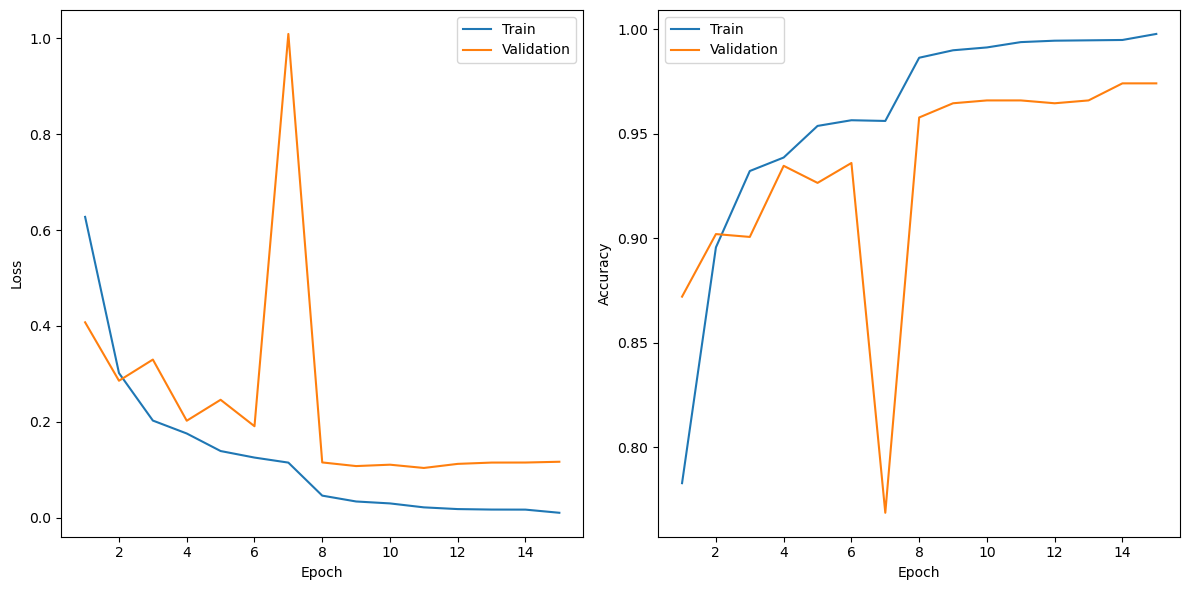

In [33]:
# Plot training and validation loss and accuracy
# Move tensors to CPU

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(range(1, nb_epochs + 1), train_loss_list, label='Train')
plt.plot(range(1, nb_epochs + 1), val_loss_list, label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, nb_epochs + 1), train_acc_list, label='Train')
plt.plot(range(1, nb_epochs + 1), val_acc_list, label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [34]:
# 모델 평가 함수 정의
def test_model(model, test_loader, device):
    model.eval()  # 모델을 평가 모드로 설정
    correct = 0
    total = 0
    with torch.no_grad():  # 그래디언트 계산 비활성화
        for inputs, labels in tqdm(test_loader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print(f'Accuracy of the model on test images: {100 * correct / total}%')


In [35]:
# 훈련 및 평가
test_model(best_model, test_loader, device)

100%|██████████| 47/47 [00:04<00:00,  9.74it/s]

Accuracy of the model on test images: 97.96472184531886%


Accuracy of the model on test images: 98.11616954474097%